In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import os, sys
path = os.path.abspath(os.path.join('..'))
if path not in sys.path:
    sys.path.append(path)
from Preprocessing.labeling import resample_close, get_t1, get_events, get_lookback_vol
from Research.fx_utils import fx_data_import, bbg_data_import
from Research.FXTesting import pca_distance_loop, get_nonusd_pair_data, get_nonusd_pairs, get_nonusd_close
from Preprocessing.sampling import _get_num_concurrent_events
from Preprocessing.etf_trick import ETFTrick
from Research.signals import lookback_zscore, zscore_signal, zscore_sizing, generate_pnl

home_machine = True
gen_tricks = False
start_date = dt.datetime(2000,1,1)
lookback = 500
# implement citi reversion



if home_machine:
    close = fx_data_import()
    nonusd_pairs = get_nonusd_pairs(close.columns)
    pair_closes = get_nonusd_close(close, nonusd_pairs)
    tr_df = pair_closes.dropna(how='any')
else:
    close, yields = bbg_data_import(vs_dollar=True)
    nonusd_pairs = get_nonusd_pairs(close.columns)
    pair_closes, cross_yields = get_nonusd_pair_data(close, yields, nonusd_pairs)
    cross_yields = cross_yields.fillna(0)/100./365.

if not gen_tricks:
    close = close.loc[start_date:]
    pair_closes = pair_closes.loc[start_date:]

#   if we wanted to drop the union of NAs
#    cross_yields = crosses.merge(yields, left_index=True, right_index=True, suffixes=('_px','_yld'))

# generate the indicator matrix whether pair is within cluster_threshold based on pca distances
group_matrix = pca_distance_loop(close, lookback, 4, 0.1, nonusd_pairs, components_to_use=[1,2,3])

# generate x-sigma signals
zscores = lookback_zscore(pair_closes, 30, lookback)
signals = zscore_signal(zscores, 2, 'Reversion')

# only take signals where the pair is 'grouped' at the time
group_signals = signals.multiply(group_matrix.loc[signals.index[0]:])
events_d = {}
tricks = []
if not gen_tricks:
    norm_srs = pd.read_excel(r"C:\Users\Brendan\FinML\MLFin\raw_data\nocarrytrickdata.xlsx", index_col=0)
    norm_srs = norm_srs.loc[start_date:]

for pair in nonusd_pairs:
    # skip if theres no group
    if (len(group_signals[pair][abs(group_signals[pair])>0]) == 0) or pair not in norm_srs.columns:
        continue
    
    print(pair, dt.datetime.now())
    
    weights = pd.DataFrame(np.ones(pair_closes.shape[0]), index=pair_closes.index, columns=[pair])
    
    # ETF trick on one pair
    # check if we're using yields
    if gen_tricks:
        if home_machine:
            carry = pd.DataFrame(np.zeros(pair_closes.shape[0]), index=pair_closes.index, columns=[pair])
            tr = ETFTrick(pair_closes.shift(1), pair_closes, weights, carry)

        else:
            tr = ETFTrick(pair_closes.shift(1), pair_closes, weights, cross_yields)
        tr_s = tr.get_etf_series()
        tricks.append(tr_s)
    else:
        tr_s = norm_srs.loc[:,pair]
        
    events0 = zscore_sizing(group_signals[pair], pair_closes[pair], 400, 50, lookback, pt_sl=(1,4))
    if events0 is None:
        continue
    events = generate_pnl(events0, tr_s)
    events_d[pair] = events



BRLCAD 2020-02-15 20:13:58.626253
BRLMXN 2020-02-15 20:13:58.777236
BRLZAR 2020-02-15 20:13:59.093069
BRLAUD 2020-02-15 20:13:59.359954
BRLNZD 2020-02-15 20:13:59.525406
CADMXN 2020-02-15 20:13:59.658322
CADNOK 2020-02-15 20:13:59.850212
CADSEK 2020-02-15 20:13:59.971164
CADZAR 2020-02-15 20:14:00.096102
CADAUD 2020-02-15 20:14:00.245016
CADNZD 2020-02-15 20:14:00.450897
CNYSLR 2020-02-15 20:14:00.631303
DKKNOK 2020-02-15 20:14:00.862195
DKKSEK 2020-02-15 20:14:01.362921
DKKCHF 2020-02-15 20:14:01.814210
DKKEUR 2020-02-15 20:14:02.001108
DKKGBP 2020-02-15 20:14:02.786229
HKDTHB 2020-02-15 20:14:03.314943
INRKRW 2020-02-15 20:14:03.431380
INRTWD 2020-02-15 20:14:03.630267
JPYSGD 2020-02-15 20:14:03.832687
JPYGBP 2020-02-15 20:14:03.986079
KRWTWD 2020-02-15 20:14:04.283919
KRWTHB 2020-02-15 20:14:04.851847
MXNZAR 2020-02-15 20:14:04.881824
NOKSEK 2020-02-15 20:14:05.141508
NOKCHF 2020-02-15 20:14:05.714246
NOKEUR 2020-02-15 20:14:05.842412
NOKGBP 2020-02-15 20:14:06.382113
SEKCHF 2020-02

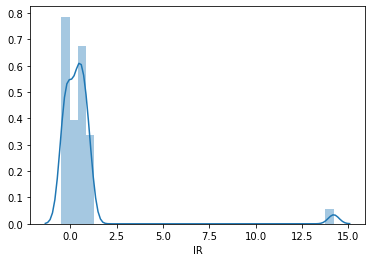

In [5]:
import seaborn as sns
cumul_pnl = pd.Series([e['ret'].sum() for key,e in events_d.items()], index=events_d.keys())
std_pnl = pd.Series([e['ret'].std() for key,e in events_d.items()], index=events_d.keys())
avg_pnl = pd.Series([e['ret'].mean() for key,e in events_d.items()], index=events_d.keys())
num_bets = pd.Series([e.shape[0] for key,e in events_d.items()], index=events_d.keys())
pnl_df = pd.concat([cumul_pnl, std_pnl, avg_pnl], axis=1, keys=['cumul','std','mean'])

# trade_ir not to be confused with strategy ir
# todo: method to generate daily mark to market
pnl_df['Trade_IR'] = pnl_df['mean']/pnl_df['std']
sns.distplot(pnl_df['Trade_IR'].dropna())

In [6]:
pnl_df

,cumul,std,mean,IR
BRLCAD,3.907513,0.314269,0.100193,0.318811
BRLMXN,-6.300998,0.726626,-0.067753,-0.093243
BRLZAR,-4.081951,0.849501,-0.050394,-0.059322
BRLAUD,4.509839,0.190882,0.100219,0.525029
BRLNZD,4.407881,0.315889,0.137746,0.436060
CADMXN,11.909389,0.328217,0.233517,0.711473
CADNOK,4.198497,0.131815,0.135435,1.027462
CADSEK,3.229334,0.007576,0.107644,14.209041
CADZAR,5.901376,0.180370,0.159497,0.884273
CADAUD,5.902429,0.326608,0.100041,0.306303
